In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
import torchvision
torch.__version__, torchvision.__version__

('1.10.1+cu102', '0.11.2+cu102')

In [3]:
from itertools import groupby
import numpy as np
import cv2
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
from pathlib import Path

import shutil
import sys
sys.path.append("../src/")
sys.path.append("./yolov5/")

import util

from joblib import Parallel, delayed

from IPython.display import display, HTML

from matplotlib import animation, rc
rc('animation', html='jshtml')

# Data

In [4]:
model_version = "0106_yolov5s_fold0_default_300ep_newcv_nobbox"
model_folder = Path(f"../output/{model_version}/")
params_path = model_folder / "config" / "params.pkl"
params = util.load_pickle(params_path)
params

{'project': 'TGBR',
 'exp_name': '0106_yolov5s_fold0_default_300ep_newcv_nobbox',
 'fold': [0],
 'data_path': PosixPath('/home/vincent/Kaggle/data/tensorflow-great-barrier-reef'),
 'remove_nobbox': True,
 'seed': 2022,
 'hyp_name': 'None',
 'copy_image': True,
 'batch': 16,
 'epochs': 50,
 'weights': 'yolov5s.pt',
 'workers': 12,
 'img_size': 1280,
 'no_train': False,
 'upload': False,
 'root_dir': PosixPath('/home/vincent/Kaggle/data/tensorflow-great-barrier-reef'),
 'image_dir': PosixPath('/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/images'),
 'label_dir': PosixPath('/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/labels'),
 'ckpt_path': PosixPath('/home/vincent/Kaggle/Kaggle_TGBR/output/0106_yolov5s_fold0_default_300ep_newcv_nobbox/TGBR/0106_yolov5s_fold0_default_300ep_newcv_nobbox/weights/best.pt'),
 'output_dir': PosixPath('/home/vincent/Kaggle/Kaggle_TGBR/output/0106_yolov5s_fold0_default_300ep_newcv_nobbox'),
 'cfg_dir': PosixPath('/home/vincent/Kaggle/Kaggle

In [5]:
# Train Data
df = pd.read_csv(params['data_path'] / 'train.csv')
df = df.progress_apply(lambda x: util.get_path(x, params, infer=False), axis=1)
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,old_image_path,image_path,label_path
0,0,40258,0,0,0-0,[],/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...
1,0,40258,1,1,0-1,[],/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...,/home/vincent/Kaggle/data/tensorflow-great-bar...


In [6]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


In [7]:
df["has_annotations"] = df["annotations"].apply(len) > 0

In [8]:
df.shape

(23501, 11)

In [9]:
23501 * 0.2093 # 5000 images with bbox

4918.759300000001

In [10]:
df.num_bbox.describe()

count    23501.000000
mean         0.506276
std          1.637906
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: num_bbox, dtype: float64

In [11]:
df.num_bbox.sum()

11898

In [12]:
df.sequence.unique()

array([40258, 45518, 59337,  8399, 45015, 35305, 53708,   996, 60510,
       44160, 15827, 29424,  8503, 18048, 17665, 60754, 37114, 26651,
       22643, 29859])

In [13]:
df.groupby("video_id")["sequence"].apply(lambda x:len(x.unique()))

video_id
0    8
1    8
2    4
Name: sequence, dtype: int64

# CV

## GroupKFold on video id and sequence

In [14]:
from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits = 5)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (_, val_idx) in enumerate(kf.split(df, y = df.video_id.tolist(), groups=df.sequence)):
    df.loc[val_idx, 'fold'] = fold

In [15]:
df.groupby("fold").size()

fold
0    4710
1    4652
2    4714
3    4712
4    4713
dtype: int64

In [16]:
df.groupby("fold")["sequence"].unique()

fold
0          [45518, 35305, 18048, 29859]
1                   [996, 15827, 60754]
2           [45015, 60510, 8503, 17665]
3          [40258, 29424, 37114, 22643]
4    [59337, 8399, 53708, 44160, 26651]
Name: sequence, dtype: object

In [17]:
df.groupby("fold")["video_id"].unique()

fold
0    [0, 1, 2]
1       [0, 1]
2       [0, 1]
3    [0, 1, 2]
4    [0, 1, 2]
Name: video_id, dtype: object

In [18]:
df.groupby("fold")["has_annotations"].mean()

fold
0    0.073248
1    0.201419
2    0.280441
3    0.182937
4    0.308296
Name: has_annotations, dtype: float64

## subsequence

In [19]:
diff_place = (df["has_annotations"] + df["sequence"]).diff()
diff_place = diff_place.shift(-1)
diff_place.iloc[-1] = 1
diff_place_filter = diff_place[diff_place!=0] 
diff_place_filter[:] =1
subsequence_id_place = diff_place_filter.cumsum()
df["subsequence_id"] = np.nan
df.loc[subsequence_id_place.index, "subsequence_id"] = subsequence_id_place.values
df["subsequence_id"] = df["subsequence_id"].fillna(method="backfill")

In [20]:
df.groupby("subsequence_id")["has_annotations"].mean().value_counts()

0.0    75
1.0    64
Name: has_annotations, dtype: int64

In [21]:
df.groupby("subsequence_id").size().describe()

count     139.000000
mean      169.071942
std       343.814781
min         1.000000
25%        27.000000
50%        63.000000
75%       154.000000
max      2800.000000
dtype: float64

In [22]:
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
skf = StratifiedGroupKFold(n_splits=5)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (_, val_idx) in enumerate(skf.split(df, groups=df['subsequence_id'], y=df["has_annotations"])):
    df.loc[val_idx, 'fold'] = fold

In [23]:
df.fold.value_counts()

1    4702
3    4701
0    4700
4    4699
2    4699
Name: fold, dtype: int64

In [24]:
df.groupby("fold")["has_annotations"].mean()

fold
0    0.209362
1    0.209485
2    0.209193
3    0.209317
4    0.209193
Name: has_annotations, dtype: float64

In [25]:
df.query("has_annotations").groupby("fold").size()

fold
0    984
1    985
2    983
3    984
4    983
dtype: int64

In [26]:
df.groupby("fold")["subsequence_id"].apply(np.unique).apply(len)

fold
0    26
1    28
2    27
3    29
4    29
Name: subsequence_id, dtype: int64

In [27]:
df.groupby("fold").size()

fold
0    4700
1    4702
2    4699
3    4701
4    4699
dtype: int64

In [28]:
df.query("has_annotations").groupby("fold").size()

fold
0    984
1    985
2    983
3    984
4    983
dtype: int64

# Model Prediction Analysis

In [29]:
params["repo"] = Path("./yolov5/").resolve()
params["augment"]  = False
params["conf"] = 0.15
params["iou"] = 0.5

In [30]:
model = util.load_model(params)
device = torch.device("cuda")
model.to(device)

YOLOv5 🚀 v6.0-184-g6865d19 torch 1.10.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11016MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): Model(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
           

In [31]:
df_oof = df.query("fold == 0").copy()
df_oof

,video_id,sequence,video_frame,sequence_frame,image_id,...,label_path,num_bbox,has_annotations,fold,subsequence_id
0,0,40258,0,0,0-0,...,/home/vincent/Kaggle/data/tensorflow-great-bar...,0,False,0,1.0
1,0,40258,1,1,0-1,...,/home/vincent/Kaggle/data/tensorflow-great-bar...,0,False,0,1.0
2,0,40258,2,2,0-2,...,/home/vincent/Kaggle/data/tensorflow-great-bar...,0,False,0,1.0
3,0,40258,3,3,0-3,...,/home/vincent/Kaggle/data/tensorflow-great-bar...,0,False,0,1.0
4,0,40258,4,4,0-4,...,/home/vincent/Kaggle/data/tensorflow-great-bar...,0,False,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
20701,2,29859,7960,188,2-7960,...,/home/vincent/Kaggle/data/tensorflow-great-bar...,0,False,0,133.0
20702,2,29859,7961,189,2-7961,...,/home/vincent/Kaggle/data/tensorflow-great-bar...,0,False,0,133.0
20703,2,29859,7962,190,2-7962,...,/home/vincent/Kaggle/data/tensorflow-great-bar...,0,False,0,133.0
20704,2,29859,7963,191,2-7963,...,/home/vincent/Kaggle/data/tensorflow-great-bar...,0,False,0,133.0


In [32]:
df_oof["real_bbox"] = None
df_oof["pred_bbox"] = None
df_oof["pred_confs"] = None

In [33]:
df_oof.columns

Index(['video_id', 'sequence', 'video_frame', 'sequence_frame', 'image_id',
       'annotations', 'old_image_path', 'image_path', 'label_path', 'num_bbox',
       'has_annotations', 'fold', 'subsequence_id', 'real_bbox', 'pred_bbox',
       'pred_confs'],
      dtype='object')

In [34]:
df_oof.reset_index(inplace=True, drop=True)

In [35]:
for idx in tqdm(range(len(df_oof))):
    row = df_oof.loc[idx]
    img_path = row["image_path"]
    annots = row["annotations"]
    real_bbox = [list(annot.values()) for annot in annots]
    img = cv2.imread(str(img_path))[...,::-1]
    break
    
    pred_bbox, confs = util.predict(model, img, size=params["img_size"], augment=params["augment"])
    df_oof.at[idx, "real_bbox"] = real_bbox
    df_oof.at[idx, "pred_bbox"] = pred_bbox.tolist()
    df_oof.at[idx, "pred_confs"] = confs

  0%|          | 0/4700 [00:00<?, ?it/s]

In [39]:
model.eval()
out, train_out = model(img, size=1280, augment=False)

TypeError: cannot unpack non-iterable Detections object

In [40]:
model(img, size=1280, augment=False).to_

In [156]:
df_oof.head()

,video_id,sequence,video_frame,sequence_frame,image_id,...,fold,subsequence_id,real_bbox,pred_bbox,pred_confs
0,0,40258,0,0,0-0,...,0,1.0,[],[],[]
1,0,40258,1,1,0-1,...,0,1.0,[],[],[]
2,0,40258,2,2,0-2,...,0,1.0,[],[],[]
3,0,40258,3,3,0-3,...,0,1.0,[],[],[]
4,0,40258,4,4,0-4,...,0,1.0,[],[],[]


In [157]:
gt_bboxs_list = []
prd_bboxs_list = []
for idx in tqdm(range(len(df_oof))):
    row = df_oof.loc[idx]
    gt_bboxs, bboxes, confis = row["real_bbox"],row["pred_bbox"], row["pred_confs"]
    prd_bboxs = [[confis[i]] + bboxes[i] for i in range(len(confis))]
    gt_bboxs, prd_bboxs = np.array(gt_bboxs), np.array(prd_bboxs)
    gt_bboxs_list.append(gt_bboxs)
    prd_bboxs_list.append(prd_bboxs)

  0%|          | 0/4700 [00:00<?, ?it/s]

In [158]:
tps, fps, fns = util.calc_f2_score(gt_bboxs_list, prd_bboxs_list, verbose=False)

In [159]:
df_oof["tp"], df_oof["fp"], df_oof["fn"] = tps, fps, fns

In [160]:
util.f_beta(*df_oof[["tp", "fp", "fn"]].sum(axis=0), beta=2) 

0.45895637598694367

In [161]:
util.f_beta(*df_oof.query("has_annotations")[["tp", "fp", "fn"]].sum(axis=0), beta=2) 

0.47172805251799865

In [164]:
color_pred = [(0,255,0)]    
color_real = [(255,0,0)]
def plot_img(df, idx):
    row = df.loc[idx]
    path = row["image_path"]
    img = cv2.imread(str(path))[...,::-1]
    real_bboxes, bboxes, confis = row["real_bbox"],row["pred_bbox"], row["pred_confs"]
    display(util.show_img(img, 
                          bboxes + real_bboxes, 
                          color_pred + color_real, 
                          bbox_format='coco', 
                          labels= [0]*len(bboxes) + [1] * len(real_bboxes))
    )

## Most FN

In [163]:
df_oof.sort_values("fn", ascending=False).head()

,video_id,sequence,video_frame,sequence_frame,image_id,...,pred_bbox,pred_confs,tp,fp,fn
1149,1,8503,4178,350,1-4178,...,"[[203, 289, 55, 48], [603, 576, 36, 32], [393,...","[0.8637048602104187, 0.8048689365386963, 0.549...",26,7,117
1146,1,8503,4175,347,1-4175,...,"[[227, 283, 59, 48], [623, 555, 37, 34], [403,...","[0.8240678906440735, 0.6805049777030945, 0.287...",27,6,116
1144,1,8503,4173,345,1-4173,...,"[[245, 286, 56, 47], [639, 547, 35, 35], [738,...","[0.8063241839408875, 0.792597234249115, 0.2824...",30,3,113
1148,1,8503,4177,349,1-4177,...,"[[209, 283, 60, 50], [609, 566, 35, 34], [390,...","[0.7942171692848206, 0.7876929044723511, 0.440...",36,8,107
1150,1,8503,4179,351,1-4179,...,"[[193, 292, 60, 48], [594, 583, 37, 36], [704,...","[0.8383798599243164, 0.6329818964004517, 0.486...",37,18,106


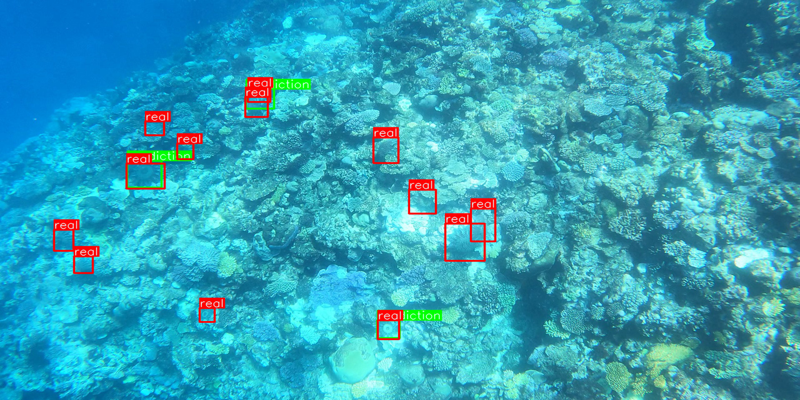

In [165]:
plot_img(df_oof, 1149)

## Most FP

In [166]:
df_oof.sort_values("fp", ascending=False).head()

,video_id,sequence,video_frame,sequence_frame,image_id,...,pred_bbox,pred_confs,tp,fp,fn
1131,1,8503,4160,332,1-4160,...,"[[280, 254, 53, 43], [648, 480, 37, 35], [1245...","[0.8387997150421143, 0.8164297342300415, 0.401...",20,35,101
1188,1,8503,4217,389,1-4217,...,"[[235, 563, 51, 48], [255, 540, 49, 41], [991,...","[0.7274391055107117, 0.4269435703754425, 0.324...",17,27,16
1190,1,8503,4219,391,1-4219,...,"[[229, 602, 55, 50], [250, 577, 50, 43], [779,...","[0.7671163082122803, 0.39564698934555054, 0.29...",18,26,15
4440,2,22643,5392,29,2-5392,...,"[[186, 71, 45, 41], [647, 689, 65, 27], [0, 18...","[0.8086417317390442, 0.49100399017333984, 0.15...",8,25,3
1043,1,8503,4072,244,1-4072,...,"[[88, 381, 50, 38], [1231, 646, 48, 71], [253,...","[0.7129290103912354, 0.3802139163017273, 0.307...",10,23,1


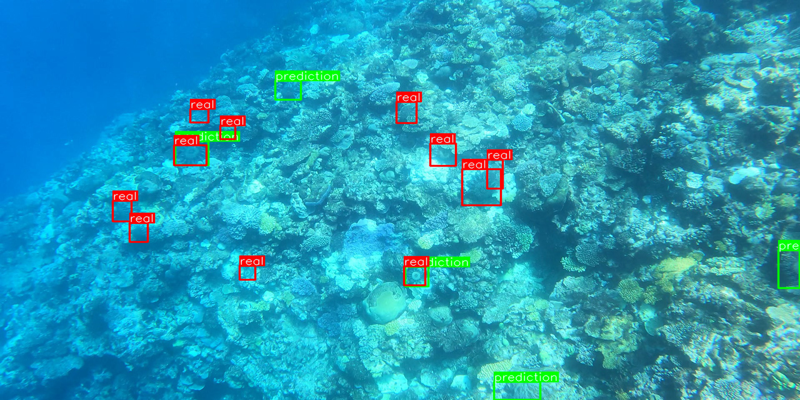

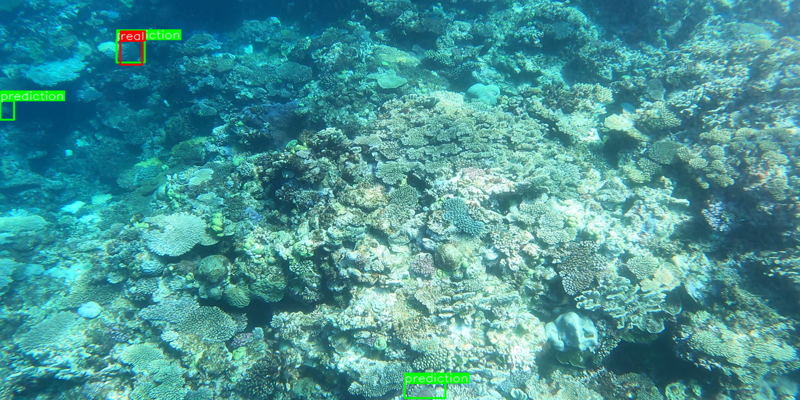

In [167]:
plot_img(df_oof, 1131)
plot_img(df_oof, 4440)

## Most TP

In [168]:
df_oof.sort_values("tp", ascending=False).head()

,video_id,sequence,video_frame,sequence_frame,image_id,...,pred_bbox,pred_confs,tp,fp,fn
1170,1,8503,4199,371,1-4199,...,"[[85, 450, 68, 57], [312, 325, 47, 43], [670, ...","[0.8421902060508728, 0.7724304795265198, 0.740...",60,6,50
1164,1,8503,4193,365,1-4193,...,"[[121, 438, 67, 54], [356, 301, 39, 34], [338,...","[0.8510955572128296, 0.6492682099342346, 0.622...",59,7,62
1183,1,8503,4212,384,1-4212,...,"[[0, 602, 71, 73], [39, 491, 52, 44], [254, 45...","[0.8276140093803406, 0.7640065550804138, 0.694...",51,4,15
1168,1,8503,4197,369,1-4197,...,"[[100, 451, 66, 55], [675, 653, 82, 65], [324,...","[0.8504600524902344, 0.7241306900978088, 0.548...",50,5,60
1156,1,8503,4185,357,1-4185,...,"[[156, 345, 63, 51], [569, 672, 35, 32], [687,...","[0.850185215473175, 0.8198478817939758, 0.7510...",48,7,95


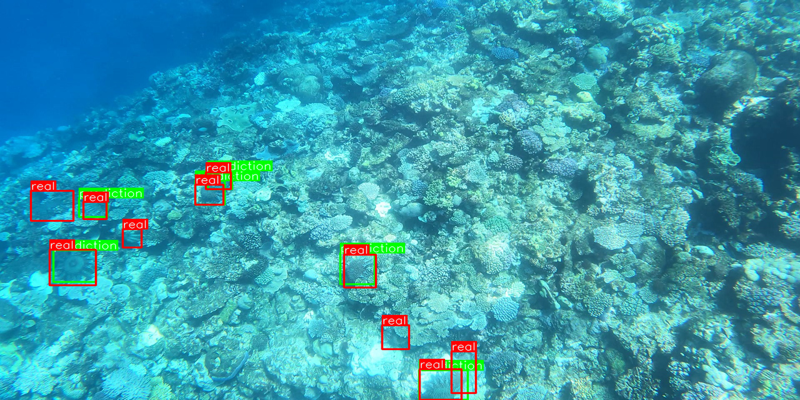

In [169]:
plot_img(df_oof, 1170)